In [5]:
!pip install lightning-utilities
!pip install torchmetrics --no-deps
!pip install torchinfo --no-deps

In [6]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import sklearn
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torchvision.transforms.functional import to_pil_image
from torchmetrics import MeanMetric, Accuracy
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, F1Score
from torchinfo import summary
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [7]:
device = "cuda" if torch.cuda.is_available() \
else "mps" if torch.backends.mps.is_available() \
else "cpu"
print(f"Using {device} device")

Using cuda device


In [9]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
data = "/content/drive/MyDrive/Deep Learning /Balanced_ISIC_Dataset"

split here call train /val /test

In [11]:
train_transform = v2.Compose([
    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Resize((224, 224)),
    v2.CenterCrop((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

In [12]:
eval_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.CenterCrop((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [13]:
train_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Deep Learning /Balanced_ISIC_Dataset/test', transform=train_transform)
val_data = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Deep Learning /Balanced_ISIC_Dataset/train', transform=eval_transform)
test_set = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Deep Learning /Balanced_ISIC_Dataset/test', transform=eval_transform)

In [14]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_indices, val_indices = torch.utils.data.random_split(range(len(train_data)), [train_size, val_size])

In [15]:
train_set = torch.utils.data.Subset(train_data, train_indices)
val_set = torch.utils.data.Subset(train_data, val_indices)

In [16]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [17]:
classes = ["mel", "oth"]
num_class = len(classes)
print("Number of classes:", num_class)

Number of classes: 2


In [18]:
def count_class_sample_number(dataset, classes):
  labels = [dataset[i][1] for i in range(len(dataset))]
  class_counts = np.bincount(labels)

  for class_label, count in enumerate(class_counts):
    print("Class", classes[class_label], "has", count, "samples.")

print("Train:")
count_class_sample_number(train_data, classes)
print("Validation:")
count_class_sample_number(val_data, classes)
print("Test:")
count_class_sample_number(test_set, classes)


Train:
Class mel has 981 samples.
Class oth has 981 samples.
Validation:
Class mel has 3924 samples.
Class oth has 3924 samples.
Test:
Class mel has 981 samples.
Class oth has 981 samples.


In [19]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    return tensor * std + mean

def visualize_data(dataset, classes, transform=None):
    sample_images = []

    for class_i in range(len(classes)):

        for image_path, label in dataset.imgs:
            if label == class_i:
                image = Image.open(image_path)
                if transform:
                    image = transform(image)
                    image = denormalize(image)

                if not isinstance(image, Image.Image):
                    image_tensor = image.clamp(0, 1)
                    image = to_pil_image(image_tensor)
                sample_images.append(image)
                break


    fig, axes = plt.subplots(1, len(classes), figsize=(10, 3))
    for i, axis in enumerate(axes.flat):
        axis.set_xticks([])
        axis.set_yticks([])
        axis.set_xlabel(classes[i], fontsize=12)
        axis.imshow(sample_images[i])

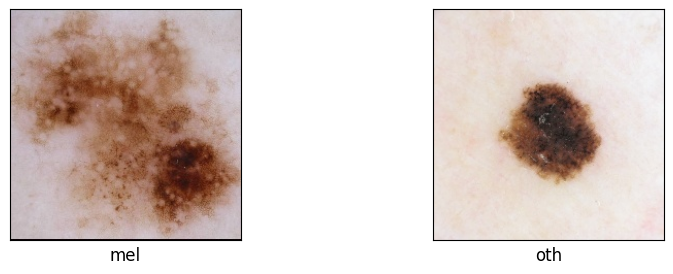

In [20]:
#without data augmentation
visualize_data(train_data, classes)

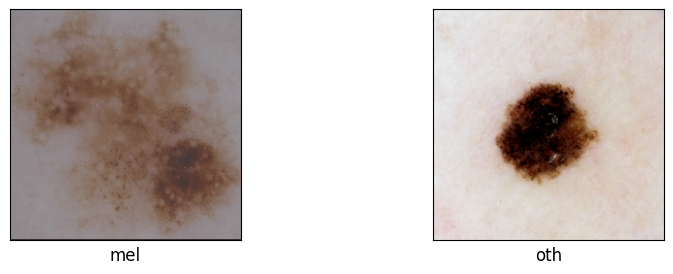

In [21]:
# with data augmentation
visualize_data(train_data, classes, train_transform)

Models

In [22]:
# Custom CNN
custom_cnn = nn.Sequential(
    nn.LazyConv2d(32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.LazyConv2d(64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.LazyLinear(len(train_data.classes))
).to(device)

In [23]:
import torchvision.models as models
# ResNet-18
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, len(train_data.classes))
resnet = resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 228MB/s]


In [24]:
# DenseNet-121
densenet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
densenet.classifier = nn.Linear(densenet.classifier.in_features, len(train_data.classes))
densenet = densenet.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 212MB/s]


In [25]:
# EfficientNet-B3
efficientnet = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, len(train_data.classes))
efficientnet = efficientnet.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 230MB/s]


In [26]:
# Dictionary of models
models_dict = {
    "Custom CNN": custom_cnn,
    "ResNet-18": resnet,
    "DenseNet-121": densenet,
    "EfficientNet-B3": efficientnet
}

In [27]:
import torch.optim as optim
from torchmetrics import Accuracy

model = models_dict["Custom CNN"].to(device)


num_classes = len(train_data.classes)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)

In [28]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


In [29]:
def validate_one_epoch(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total


In [30]:
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_dataloader, criterion, optimizer)
    val_loss, val_acc = validate_one_epoch(model, val_dataloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch 1/10
Train Loss: 1.2785 | Train Accuracy: 0.5953
Val   Loss: 0.6430 | Val Accuracy: 0.6718
Epoch 2/10
Train Loss: 0.6313 | Train Accuracy: 0.6756
Val   Loss: 0.5881 | Val Accuracy: 0.7074
Epoch 3/10
Train Loss: 0.6074 | Train Accuracy: 0.6794
Val   Loss: 0.6159 | Val Accuracy: 0.6972
Epoch 4/10
Train Loss: 0.5956 | Train Accuracy: 0.6845
Val   Loss: 0.5720 | Val Accuracy: 0.7074
Epoch 5/10
Train Loss: 0.6003 | Train Accuracy: 0.6839
Val   Loss: 0.5758 | Val Accuracy: 0.7048
Epoch 6/10
Train Loss: 0.5978 | Train Accuracy: 0.6909
Val   Loss: 0.5837 | Val Accuracy: 0.6819
Epoch 7/10
Train Loss: 0.5880 | Train Accuracy: 0.6896
Val   Loss: 0.5886 | Val Accuracy: 0.6972
Epoch 8/10
Train Loss: 0.5717 | Train Accuracy: 0.7138
Val   Loss: 0.5856 | Val Accuracy: 0.7405
Epoch 9/10
Train Loss: 0.5637 | Train Accuracy: 0.7170
Val   Loss: 0.6261 | Val Accuracy: 0.6819
Epoch 10/10
Train Loss: 0.6617 | Train Accuracy: 0.6189
Val   Loss: 0.6657 | Val Accuracy: 0.6234


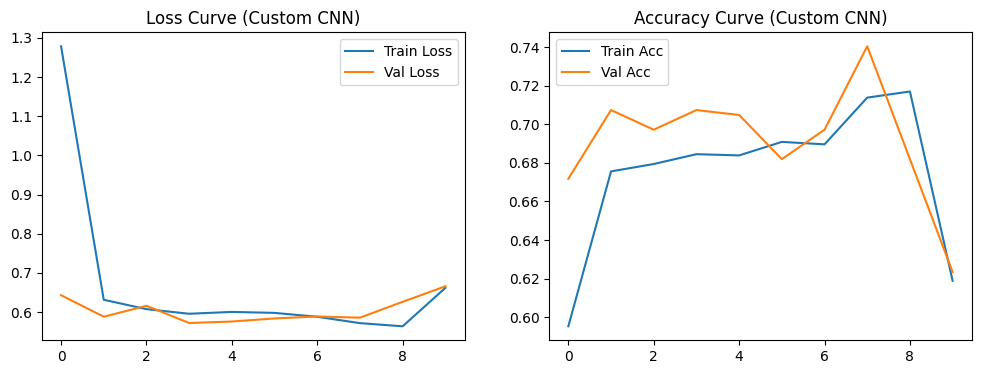

In [31]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve (Custom CNN)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy Curve (Custom CNN)')
plt.legend()

plt.show()

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np


In [33]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


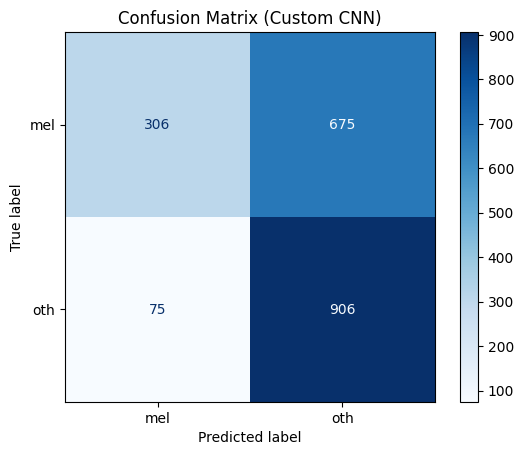

In [34]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Custom CNN)")
plt.show()


In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F

def compute_roc(model, dataloader):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)[:, 1]  # Prob for class "oth"
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


In [36]:
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

         mel       0.80      0.31      0.45       981
         oth       0.57      0.92      0.71       981

    accuracy                           0.62      1962
   macro avg       0.69      0.62      0.58      1962
weighted avg       0.69      0.62      0.58      1962



In [37]:
model = models_dict["DenseNet-121"].to(device)

num_classes = len(train_data.classes)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)


In [38]:
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_dataloader, criterion, optimizer)
    val_loss, val_acc = validate_one_epoch(model, val_dataloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")

Epoch 1/10
Train Loss: 0.6084 | Train Accuracy: 0.6947
Val   Loss: 0.6709 | Val Accuracy: 0.7430
Epoch 2/10
Train Loss: 0.5345 | Train Accuracy: 0.7374
Val   Loss: 0.9389 | Val Accuracy: 0.7532
Epoch 3/10
Train Loss: 0.5375 | Train Accuracy: 0.7406
Val   Loss: 0.5855 | Val Accuracy: 0.7252
Epoch 4/10
Train Loss: 0.5271 | Train Accuracy: 0.7476
Val   Loss: 0.4946 | Val Accuracy: 0.7150
Epoch 5/10
Train Loss: 0.5138 | Train Accuracy: 0.7514
Val   Loss: 0.5119 | Val Accuracy: 0.7303
Epoch 6/10
Train Loss: 0.4913 | Train Accuracy: 0.7718
Val   Loss: 0.4899 | Val Accuracy: 0.7684
Epoch 7/10
Train Loss: 0.4988 | Train Accuracy: 0.7597
Val   Loss: 0.5584 | Val Accuracy: 0.6947
Epoch 8/10
Train Loss: 0.5067 | Train Accuracy: 0.7489
Val   Loss: 0.4642 | Val Accuracy: 0.7710
Epoch 9/10
Train Loss: 0.4750 | Train Accuracy: 0.7737
Val   Loss: 0.4780 | Val Accuracy: 0.7710
Epoch 10/10
Train Loss: 0.5239 | Train Accuracy: 0.7706
Val   Loss: 0.7286 | Val Accuracy: 0.7405


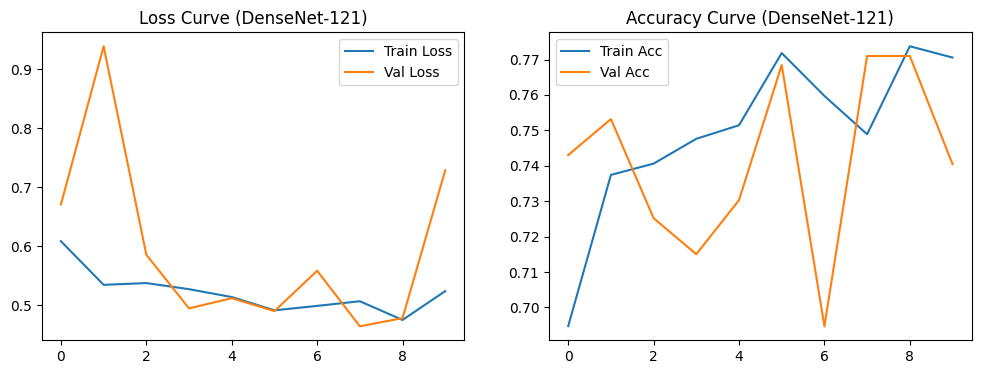

In [39]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve (DenseNet-121)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy Curve (DenseNet-121)')
plt.legend()
plt.show()

In [40]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

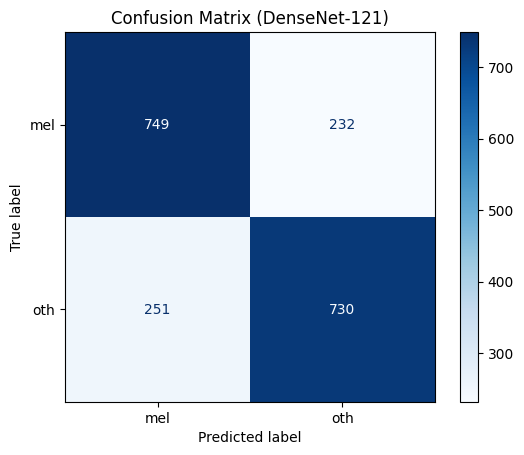

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (DenseNet-121)")
plt.show()

In [42]:
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

         mel       0.75      0.76      0.76       981
         oth       0.76      0.74      0.75       981

    accuracy                           0.75      1962
   macro avg       0.75      0.75      0.75      1962
weighted avg       0.75      0.75      0.75      1962



In [43]:
model = models_dict["ResNet-18"].to(device)

num_classes = len(train_data.classes)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)

In [44]:
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_dataloader, criterion, optimizer)
    val_loss, val_acc = validate_one_epoch(model, val_dataloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch 1/10
Train Loss: 0.7022 | Train Accuracy: 0.7081
Val   Loss: 0.5968 | Val Accuracy: 0.7354
Epoch 2/10
Train Loss: 0.5679 | Train Accuracy: 0.7304
Val   Loss: 0.5688 | Val Accuracy: 0.7023
Epoch 3/10
Train Loss: 0.5467 | Train Accuracy: 0.7234
Val   Loss: 0.5143 | Val Accuracy: 0.7659
Epoch 4/10
Train Loss: 0.5134 | Train Accuracy: 0.7680
Val   Loss: 0.5477 | Val Accuracy: 0.7735
Epoch 5/10
Train Loss: 0.5307 | Train Accuracy: 0.7431
Val   Loss: 0.5772 | Val Accuracy: 0.7201
Epoch 6/10
Train Loss: 0.5450 | Train Accuracy: 0.7438
Val   Loss: 0.6387 | Val Accuracy: 0.7150
Epoch 7/10
Train Loss: 0.5334 | Train Accuracy: 0.7310
Val   Loss: 0.5013 | Val Accuracy: 0.7735
Epoch 8/10
Train Loss: 0.5005 | Train Accuracy: 0.7661
Val   Loss: 0.5619 | Val Accuracy: 0.7354
Epoch 9/10
Train Loss: 0.4750 | Train Accuracy: 0.7916
Val   Loss: 0.5225 | Val Accuracy: 0.7710
Epoch 10/10
Train Loss: 0.4753 | Train Accuracy: 0.7757
Val   Loss: 0.5063 | Val Accuracy: 0.7684


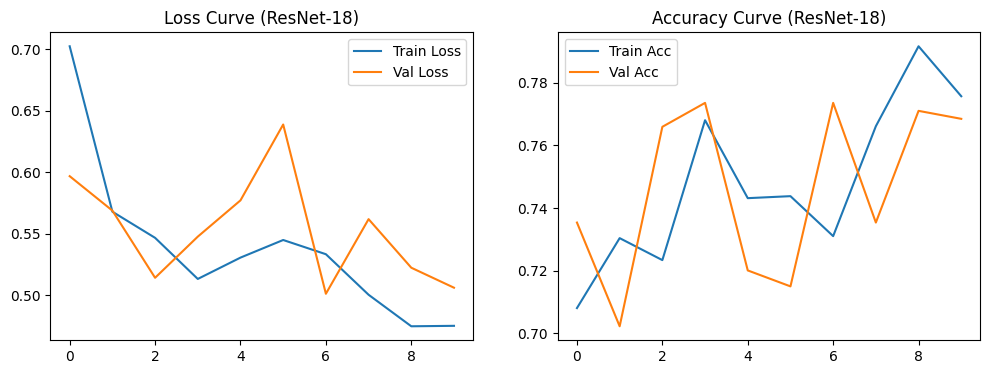

In [45]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve (ResNet-18)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy Curve (ResNet-18)')
plt.legend()
plt.show()


In [46]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


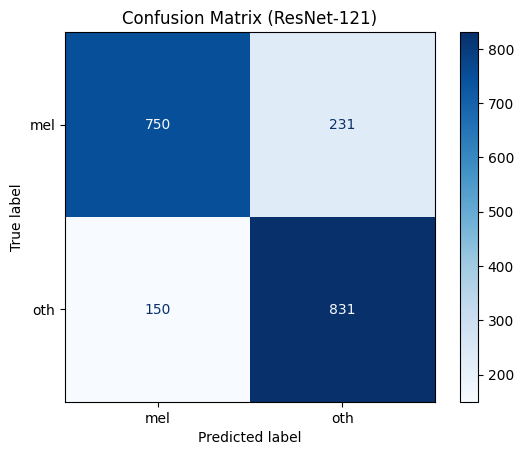

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (ResNet-121)")
plt.show()

In [48]:
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

         mel       0.83      0.76      0.80       981
         oth       0.78      0.85      0.81       981

    accuracy                           0.81      1962
   macro avg       0.81      0.81      0.81      1962
weighted avg       0.81      0.81      0.81      1962



In [49]:
model = models_dict["EfficientNet-B3"].to(device)

num_classes = len(train_data.classes)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)

In [50]:
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_dataloader, criterion, optimizer)
    val_loss, val_acc = validate_one_epoch(model, val_dataloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}")


Epoch 1/10
Train Loss: 0.5303 | Train Accuracy: 0.7412
Val   Loss: 0.4981 | Val Accuracy: 0.7786
Epoch 2/10
Train Loss: 0.4532 | Train Accuracy: 0.7929
Val   Loss: 0.4146 | Val Accuracy: 0.8015
Epoch 3/10
Train Loss: 0.4050 | Train Accuracy: 0.8088
Val   Loss: 0.5012 | Val Accuracy: 0.7735
Epoch 4/10
Train Loss: 0.3693 | Train Accuracy: 0.8368
Val   Loss: 0.5411 | Val Accuracy: 0.7684
Epoch 5/10
Train Loss: 0.3028 | Train Accuracy: 0.8713
Val   Loss: 0.5826 | Val Accuracy: 0.7735
Epoch 6/10
Train Loss: 0.3008 | Train Accuracy: 0.8783
Val   Loss: 0.6548 | Val Accuracy: 0.8015
Epoch 7/10
Train Loss: 0.2756 | Train Accuracy: 0.8936
Val   Loss: 0.6453 | Val Accuracy: 0.7684
Epoch 8/10
Train Loss: 0.2216 | Train Accuracy: 0.9146
Val   Loss: 0.5018 | Val Accuracy: 0.8015
Epoch 9/10
Train Loss: 0.2012 | Train Accuracy: 0.9229
Val   Loss: 0.5444 | Val Accuracy: 0.7710
Epoch 10/10
Train Loss: 0.1421 | Train Accuracy: 0.9465
Val   Loss: 0.8558 | Val Accuracy: 0.7710


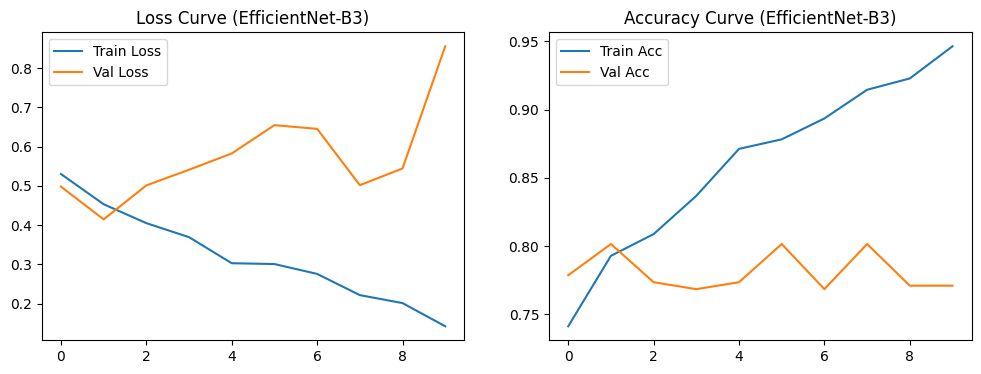

In [51]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve (EfficientNet-B3)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy Curve (EfficientNet-B3)')
plt.legend()
plt.show()

In [52]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


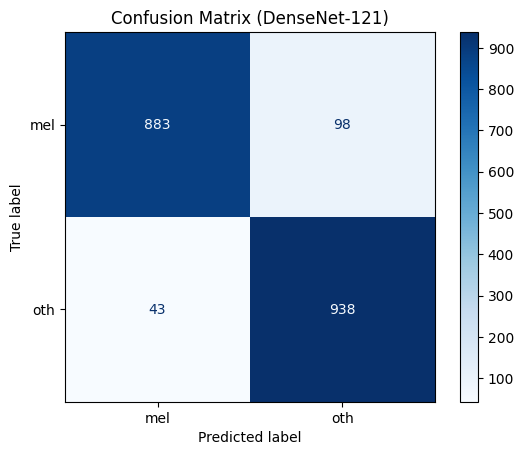

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (DenseNet-121)")
plt.show()

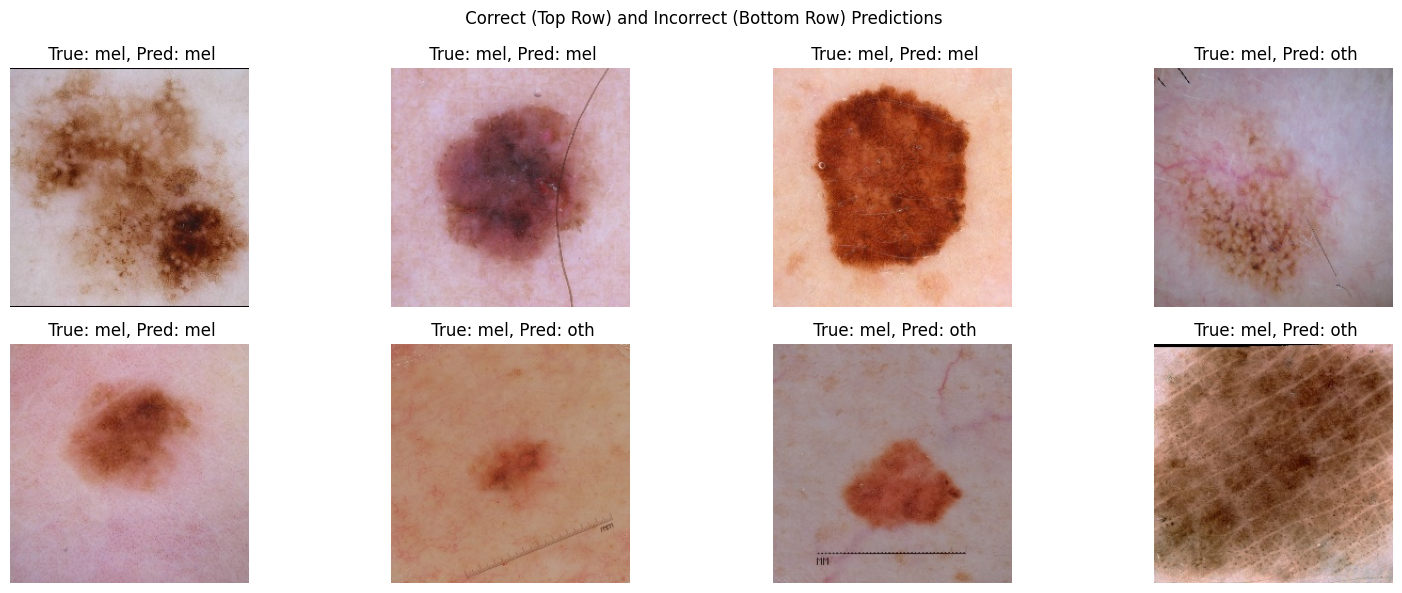

In [54]:
model = models_dict["EfficientNet-B3"].to(device)
model.eval()

correct_images = []
incorrect_images = []
true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        for img, label, pred in zip(images, labels, preds):
            if label == pred and len(correct_images) < 4:
                correct_images.append(img.cpu())
                true_labels.append(label.cpu())
                pred_labels.append(pred.cpu())
            elif label != pred and len(incorrect_images) < 4:
                incorrect_images.append(img.cpu())
                true_labels.append(label.cpu())
                pred_labels.append(pred.cpu())
            if len(correct_images) >= 4 and len(incorrect_images) >= 4:
                break

fig, axs = plt.subplots(2, 4, figsize=(16, 6))
for i in range(4):
    img = correct_images[i]
    axs[0, i].imshow(denormalize(img).permute(1, 2, 0))
    axs[0, i].set_title(f" True: {classes[true_labels[i]]}, Pred: {classes[pred_labels[i]]}")
    axs[0, i].axis("off")

for i in range(4):
    img = incorrect_images[i]
    axs[1, i].imshow(denormalize(img).permute(1, 2, 0))
    axs[1, i].set_title(f" True: {classes[true_labels[i+4]]}, Pred: {classes[pred_labels[i+4]]}")
    axs[1, i].axis("off")

plt.suptitle(" Correct (Top Row) and Incorrect (Bottom Row) Predictions")
plt.tight_layout()
plt.show()

In [55]:
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)
print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

         mel       0.95      0.90      0.93       981
         oth       0.91      0.96      0.93       981

    accuracy                           0.93      1962
   macro avg       0.93      0.93      0.93      1962
weighted avg       0.93      0.93      0.93      1962



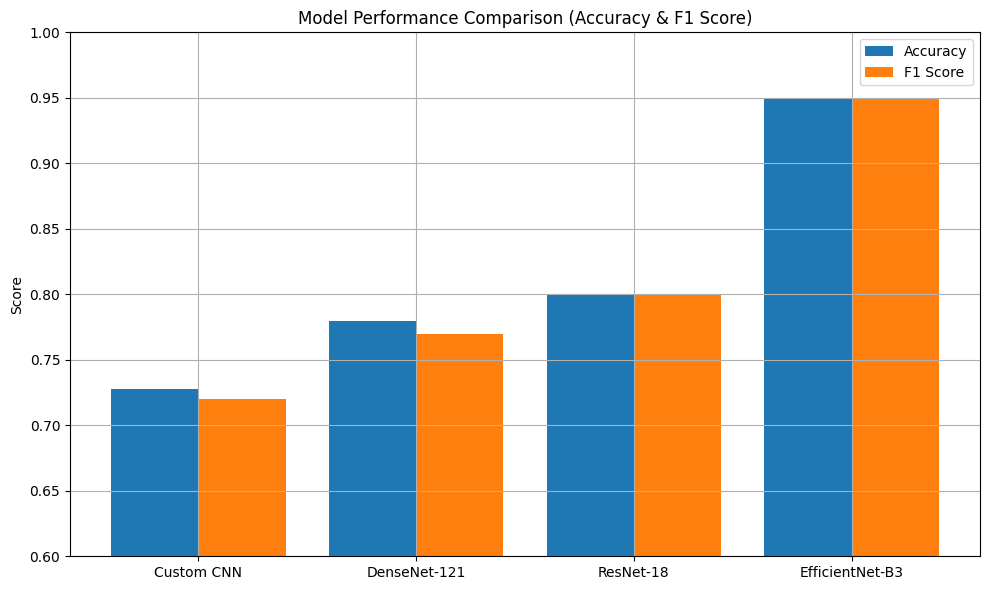

In [56]:
import matplotlib.pyplot as plt


model_names = ["Custom CNN", "DenseNet-121", "ResNet-18", "EfficientNet-B3"]
accuracies = [0.728, 0.78, 0.80, 0.95]
f1_scores = [0.72, 0.77, 0.80, 0.95]

x = range(len(model_names))

plt.figure(figsize=(10,6))
plt.bar(x, accuracies, width=0.4, label='Accuracy', align='center')
plt.bar([i + 0.4 for i in x], f1_scores, width=0.4, label='F1 Score', align='center')

plt.xticks([i + 0.2 for i in x], model_names)
plt.ylim(0.6, 1.0)
plt.ylabel("Score")
plt.title("Model Performance Comparison (Accuracy & F1 Score)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()